In [2]:
!pip install pyspark

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import pyspark
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder.appName("Datacamp Pyspark Tutorial").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

In [6]:
df = spark.read.csv('datacamp_ecommerce.csv',header=True,escape="\"")

In [7]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
+---------+---------+-----------------------------------+--------+------

In [8]:
df.count()

100

In [9]:
df.head()

Row(InvoiceNo='536365', StockCode='85123A', Description='WHITE HANGING HEART T-LIGHT HOLDER', Quantity='6', InvoiceDate='12/1/10 8:26', UnitPrice='2.55', CustomerID='17850', Country='United Kingdom')

In [11]:
df.select('CustomerID').distinct().count()

7

In [12]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).show()

+--------------+-------------+
|       Country|country_count|
+--------------+-------------+
|        France|            1|
|United Kingdom|            6|
+--------------+-------------+



In [13]:
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+--------------+-------------+
|       Country|country_count|
+--------------+-------------+
|United Kingdom|            6|
|        France|            1|
+--------------+-------------+



In [14]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',to_timestamp("InvoiceDate", 'yy/MM/dd HH:mm'))
df.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2012-01-10 09:37:00|
+-------------------+



In [15]:
df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2012-01-10 08:26:00|
+-------------------+



In [16]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2.55     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2.75     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3.39     |17850     |United Kingdom|2012-01-10 08:26:00|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEA

In [17]:
df = df.withColumn("from_date", lit("12/1/10 08:26"))
df = df.withColumn('from_date',to_timestamp("from_date", 'yy/MM/dd HH:mm'))

df2 = df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))

In [18]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')

In [19]:
df2.show(5,0)

+-------+---------+---------+-------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|recency|InvoiceNo|StockCode|Description                    |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |from_date          |
+-------+---------+---------+-------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|540    |536369   |21756    |BATH BUILDING BLOCK WORD       |3       |12/1/10 8:35|5.95     |13047     |United Kingdom|2012-01-10 08:35:00|2012-01-10 08:26:00|
|1140   |536370   |22728    |ALARM CLOCK BAKELIKE PINK      |24      |12/1/10 8:45|3.75     |12583     |France        |2012-01-10 08:45:00|2012-01-10 08:26:00|
|1140   |536370   |22727    |ALARM CLOCK BAKELIKE RED       |24      |12/1/10 8:45|3.75     |12583     |France        |2012-01-10 08:45:00|2012-01-10 08:26:00|
|1140   |536370   |22726    |ALARM CLOCK

In [20]:
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



In [21]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))

In [22]:
df_freq.show(5,0)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|15100     |1        |
|15291     |2        |
|17850     |18       |
|13748     |1        |
|12583     |20       |
+----------+---------+
only showing top 5 rows



In [23]:
df3 = df2.join(df_freq,on='CustomerID',how='inner')

In [24]:
df3.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



In [25]:
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))

In [44]:
finaldf = m_val.join(df3,on='CustomerID',how='inner')

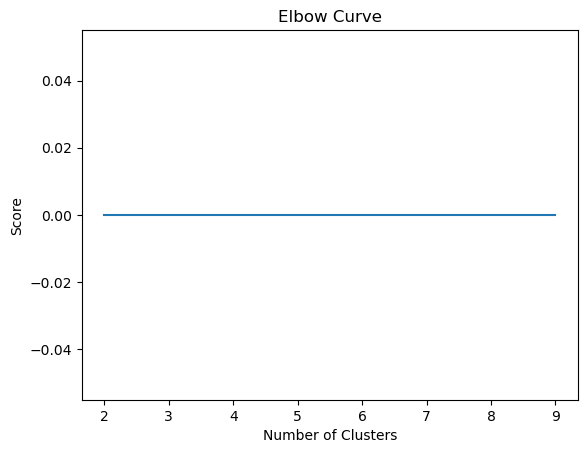

In [46]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()